# Model Building
Here is where the project's focus shifted to leveraging the power of deep learning to predict sales performance. We're using the 'title' column to build a Convolutional Neural Network (CNN) with Keras for a binary classification task to predict 'target' (the likelihood of a product selling over 100 units)  using GloVe embeddings for the 'title' column.

Further iterations would include other features in the dataset.

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, Input, concatenate, SpatialDropout1D, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

pd.set_option('display.max_columns', None)

# !pip install tensorflow==2.10.0
print(tf.__version__)

2.15.0


### Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv("/content/drive/My Drive/feature_engineering.csv")

In [8]:
df.head(1)

,title,img_url,product_url,stars,reviews,price,is_best_seller,category_name,discount_percent,target
0,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,False,Suitcases,0.0,1


### Prepare Feature and Target Variables

In [9]:
X = df['title'].values
y = df['target'].values

In [10]:
len(X)

1426337

In [11]:
len(y)

1426337

In [12]:
X

array(['Sion Softside Expandable Roller Luggage, Black, Checked-Large 29-Inch',
       'Luggage Sets Expandable PC+ABS Durable Suitcase Double Wheels TSA Lock Blue',
       'Platinum Elite Softside Expandable Checked Luggage, 8 Wheel Spinner Suitcase, TSA Lock, Men and Women, True Navy Blue, Checked Medium 25-Inch',
       ...,
       'Newest Wireless Android Auto Car Adapter for OEM Factory Wired Android Auto Cars, Plug & Play Easy Setup Wireless Android Auto Dongle for Android Phones Converts Wired Android Auto to Wireless',
       'Android 11 Car Radio for Jeep Wrangler 2011 2012 2013 2014 with Apple Carplay and Android Auto 10.1 inch Touch Screen Car Stereo with AHD Backup Camera/Mic/HiFi',
       'RED WOLF Radio Wiring Harness w/Antenna Adapter Plug Fit for 2010-2019 Toyota Tacoma 4Runner Camry Install Aftermarket Stereo Wire Cable Adapter Connector'],
      dtype=object)

### Splitting the dataset into train and test sets

In [13]:
# stratify the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [14]:
# validating number of records in train and test
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1141069
1141069
285268
285268


In [15]:
# Let's get the lengths of the titles
title_len = [len(x.split()) for x in X]

In [16]:
# Getting percentiles of title lengths to determine max text length
np.percentile(title_len, [0, 25, 50, 90, 95, 99])

array([ 1., 12., 19., 30., 32., 36.])

**Set Maximum Features and Text Length**

In [17]:
# parameters
max_features = 10000  # Only consider the top 10k words in the dataset
max_text_length = 32 # maximum length of text sequences set at 95th percentile

**Initialize and fit the tokenizer**

In [18]:
X_tokenizer = Tokenizer(max_features)
X_tokenizer.fit_on_texts(list(X_train))

In [19]:
# Save tokenizer as pickle file for model.py in project to be deployed
pickle_file_path = '../content/drive/My Drive/X_tokenizer.pickle'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(X_tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)

**Convert Texts to Sequences and Pad the Sequences**

In [20]:
# Convert text to sequences of integers and pad them
X_train_tokenized = X_tokenizer.texts_to_sequences(X_train)
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=max_text_length)

## Load GloVe Embeddings
Load the pre-trained GloVe embeddings into memory. Ensure you have downloaded the appropriate GloVe file.

In [21]:
embedding_dim = 100
embeddings_index = dict()
f = open('../content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


- Print statement is showing number of word vectors in the GloVe embedding matrix

In [22]:
# Initialize the Embedding Matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
# Populate the Embedding Matrix
for word, index in X_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [23]:
embedding_matrix.shape

(10000, 100)

## Define model architecture
Outline the architecture of your CNN model with a combination of text and other features.

**Define Embedding Layer**

This architecture utilizes a series of convolutional layers to learn patterns in text data at various scales, using residual connections and pooling layers to structure the learning process efficiently. The use of pre-trained embeddings allows it to leverage prior knowledge about word similarities, and the final dense layers focus the learned representations down to a single predictive output. This kind of model can be quite powerful for text classification tasks, especially when dealing with large datasets and complex patterns.

In [24]:
main_input = Input(shape=(max_text_length,))
embedding_layer = Embedding(max_features,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(
                                embedding_matrix),
                            trainable=False)(main_input)
text_embed = SpatialDropout1D(0.2)(embedding_layer)

repeat = 6
size = max_text_length

region_x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(text_embed)
x = Activation(activation='relu')(region_x)
x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(x)
x = Activation(activation='relu')(x)
x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(x)
x = Activation(activation='relu')(x)
x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(x)
x = Add()([x, region_x])

for _ in range(repeat):
    px = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    size = int((size + 1) / 2)
    x = Activation(activation='relu')(px)
    x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(x)
    x = Activation(activation='relu')(x)
    x = Conv1D(filters=250, kernel_size=3, padding='same', strides=1)(x)
    x = Add()([x, px])

x = MaxPooling1D(pool_size=size)(x)
x = Flatten()(x)
dropout = Dropout(0.25)(x)
final_input = Dense(256, activation = 'relu')(dropout)
main_output = Dense(1, activation='sigmoid')(final_input)

In [25]:
model = Model(inputs =  [main_input], outputs = [main_output])

## Compile the Model

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])

## Define callbacks

In [27]:
early_stopping = EarlyStopping(monitor='val_precision', restore_best_weights=True, patience=5)
checkpoint = ModelCheckpoint("../content/drive/My Drive/model_weights_{epoch:02d}.h5", save_weights_only=True, save_freq='epoch')

## Train the Model

In [28]:
batch_size = 32
epochs = 3

history = model.fit(X_train_padded, y_train,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint],
                    validation_split=0.2)

Epoch 1/3
28527/28527 [==============================] - 296s 10ms/step - loss: 0.4573 - precision: 0.6435 - recall: 0.3244 - val_loss: 0.4478 - val_precision: 0.6955 - val_recall: 0.3486
Epoch 2/3
28527/28527 [==============================] - 283s 10ms/step - loss: 0.4362 - precision: 0.6671 - recall: 0.3744 - val_loss: 0.4226 - val_precision: 0.6412 - val_recall: 0.4640
Epoch 3/3
28527/28527 [==============================] - 285s 10ms/step - loss: 0.4473 - precision: 0.6730 - recall: 0.3811 - val_loss: 0.4276 - val_precision: 0.7499 - val_recall: 0.2974


## Evaluate the Model

**Preparing the Test Data**

**Tokenizing and Padding the Test Data**

In [29]:
# Convert text to sequences of integers and pad them
X_test_tokenized = X_tokenizer.texts_to_sequences(X_test)
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=max_text_length)

**Making Predictions with the Model**

In [30]:
# Use the model to predict the target values for the test data
y_testing = model.predict(X_test_padded, verbose=1, batch_size=32)

8915/8915 [==============================] - 24s 3ms/step


**Create confusion matrix**

In [31]:
# Convert probabilities to binary predictions with a 0.7 threshold
y_pred = (y_testing > 0.7).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

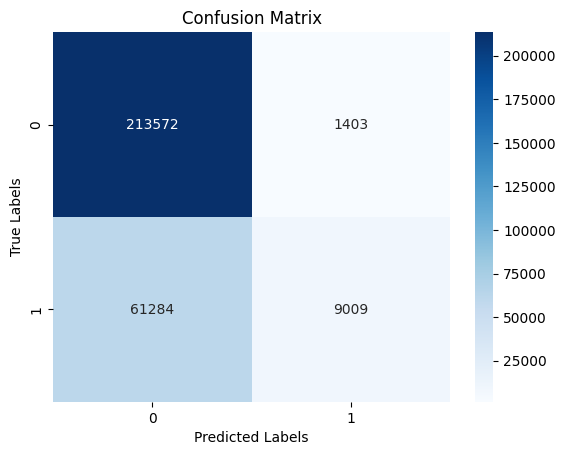

In [32]:
# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and a title for clarity
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In the context of this tool, a high precision rate ensures that when our model predicts a product title is likely to sell more than 100 units, it is correct most of the time, thus enabling Amazon sellers to make informed decisions about inventory and marketing investments based on these predictions.

**Evaluate the Model on the test set**

In [33]:
model.evaluate(X_test_padded, y_test, batch_size=32)

8915/8915 [==============================] - 32s 4ms/step - loss: 0.4276 - precision: 0.7531 - recall: 0.2978


[0.4276149868965149, 0.7530761957168579, 0.29776790738105774]

After training our model, we have evaluated its performance on the test set to understand how well it generalizes to new, unseen data. Here's an overview of the evaluation metrics:

- **Precision (0.7531)**: Precision is a key metric for our model, especially considering its application in predicting whether product titles are likely to achieve sales volumes above 100 units. A precision of 0.7531 indicates that out of all the product titles our model predicted to sell more than 100 units, 75.31% of them were correct. This is quite significant as it implies that the model's predictions are reliable to a certain extent.

In [34]:
model.save("../content/drive/My Drive/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
